In [1]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from PIL import Image
import mediapipe as mp
import argparse

def create_directory(directory):
    """Create directory if it doesn't exist."""
    if not os.path.exists(directory):
        os.makedirs(directory)

def process_image(image_path, output_path, mp_hands, method='mediapipe'):
    """
    Remove background from hand image using either MediaPipe or color segmentation.
    
    Args:
        image_path: Path to input image
        output_path: Path to save processed image
        mp_hands: MediaPipe hands model
        method: 'mediapipe' or 'color_segmentation'
    """
    # Read image with OpenCV (BGR format)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read {image_path}")
        return
    
    # Convert to RGB for MediaPipe
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape
    
    if method == 'mediapipe':
        # Process with MediaPipe hands
        results = mp_hands.process(rgb_image)
        
        # Create a black mask
        mask = np.zeros((h, w), dtype=np.uint8)
        
        # If hand landmarks are detected
        if results.multi_hand_landmarks:
            # Create a convex hull from the hand landmarks
            for hand_landmarks in results.multi_hand_landmarks:
                points = []
                for landmark in hand_landmarks.landmark:
                    x, y = int(landmark.x * w), int(landmark.y * h)
                    points.append([x, y])
                
                # Convert points to numpy array
                points = np.array(points, dtype=np.int32)
                
                # Calculate the convex hull (to get the entire hand shape)
                hull = cv2.convexHull(points)
                
                # Draw the convex hull on the mask
                cv2.fillConvexPoly(mask, hull, 255)
                
                # Add padding around the hand (expand the mask by dilating)
                kernel = np.ones((15, 15), np.uint8)
                mask = cv2.dilate(mask, kernel, iterations=1)
    
    elif method == 'color_segmentation':
        # Convert to HSV for better color segmentation
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # Define range for skin color in HSV
        # Adjust these ranges based on your lighting conditions and skin tones
        lower_skin = np.array([0, 20, 70], dtype=np.uint8)
        upper_skin = np.array([20, 255, 255], dtype=np.uint8)
        
        # Create a binary mask
        mask = cv2.inRange(hsv, lower_skin, upper_skin)
        
        # Apply morphological operations to improve the mask
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.dilate(mask, kernel, iterations=2)
        mask = cv2.erode(mask, kernel, iterations=1)
        mask = cv2.GaussianBlur(mask, (5, 5), 0)
    
    # Apply the mask to extract the hand
    result = image.copy()
    
    # Create alpha channel (transparent background)
    rgba = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
    
    # Set alpha value to 0 (transparent) for background pixels
    rgba[:, :, 3] = mask
    
    # Save the result as PNG to preserve transparency
    cv2.imwrite(output_path, rgba)

def process_dataset(data_path, output_path, background_removal_method='mediapipe'):
    """
    Process the entire dataset to remove backgrounds from hand gesture images.
    
    Args:
        data_path: Path to the original dataset
        output_path: Path to save the processed dataset
        background_removal_method: 'mediapipe' or 'color_segmentation'
    """
    # Initialize MediaPipe Hands
    mp_hands = mp.solutions.hands.Hands(
        static_image_mode=True,
        max_num_hands=2,
        min_detection_confidence=0.5
    )
    
    # Create output directory
    create_directory(output_path)
    
    # Iterate through gesture folders
    for gesture in ['down', 'left', 'right', 'up']:
        gesture_path = os.path.join(data_path, gesture)
        output_gesture_path = os.path.join(output_path, gesture)
        create_directory(output_gesture_path)
        
        print(f"Processing gesture: {gesture}")
        
        # Iterate through sequence folders for this gesture
        seq_folders = [f for f in os.listdir(gesture_path) if os.path.isdir(os.path.join(gesture_path, f))]
        
        for seq_folder in tqdm(seq_folders, desc=f"Processing {gesture} sequences"):
            seq_path = os.path.join(gesture_path, seq_folder)
            output_seq_path = os.path.join(output_gesture_path, seq_folder)
            create_directory(output_seq_path)
            
            # Process frames in this sequence
            frame_files = [f for f in os.listdir(seq_path) if f.endswith('.jpg') or f.endswith('.png')]
            
            for frame_file in frame_files:
                frame_path = os.path.join(seq_path, frame_file)
                output_frame_path = os.path.join(output_seq_path, frame_file.replace('.jpg', '.png'))
                
                # Process the image to remove background
                process_image(frame_path, output_frame_path, mp_hands, method=background_removal_method)
    
    # Release MediaPipe resources
    mp_hands.close()

def main():
    parser = argparse.ArgumentParser(description='Remove background from hand gesture images')
    parser.add_argument('--input', type=str, required=True, help='Path to the original dataset')
    parser.add_argument('--output', type=str, required=True, help='Path to save the processed dataset')
    parser.add_argument('--method', type=str, default='mediapipe', choices=['mediapipe', 'color_segmentation'],
                        help='Background removal method (mediapipe or color_segmentation)')
    
    args = parser.parse_args()
    
    # Process the dataset
    process_dataset(args.input, args.output, args.method)
    print(f"Dataset processing complete. Results saved to {args.output}")

if __name__ == "__main__":
    main()

usage: ipykernel_launcher.py [-h] --input INPUT --output OUTPUT [--method {mediapipe,color_segmentation}]
ipykernel_launcher.py: error: the following arguments are required: --input, --output


SystemExit: 2

C:\Softwares\Annaconda\lib\site-packages\IPython\core\interactiveshell.py:3452: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
# Import necessary libraries
import os
import numpy as np
import cv2
from tqdm.notebook import tqdm  # Use tqdm.notebook for better Jupyter integration
from PIL import Image
import mediapipe as mp
import matplotlib.pyplot as plt

def create_directory(directory):
    """Create directory if it doesn't exist."""
    if not os.path.exists(directory):
        os.makedirs(directory)

def process_image(image_path, output_path, mp_hands, method='mediapipe'):
    """
    Remove background from hand image using either MediaPipe or color segmentation.
    
    Args:
        image_path: Path to input image
        output_path: Path to save processed image
        mp_hands: MediaPipe hands model
        method: 'mediapipe' or 'color_segmentation'
    """
    # Read image with OpenCV (BGR format)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read {image_path}")
        return
    
    # Convert to RGB for MediaPipe
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape
    
    if method == 'mediapipe':
        # Process with MediaPipe hands
        results = mp_hands.process(rgb_image)
        
        # Create a black mask
        mask = np.zeros((h, w), dtype=np.uint8)
        
        # If hand landmarks are detected
        if results.multi_hand_landmarks:
            # Create a convex hull from the hand landmarks
            for hand_landmarks in results.multi_hand_landmarks:
                points = []
                for landmark in hand_landmarks.landmark:
                    x, y = int(landmark.x * w), int(landmark.y * h)
                    points.append([x, y])
                
                # Convert points to numpy array
                points = np.array(points, dtype=np.int32)
                
                # Calculate the convex hull (to get the entire hand shape)
                hull = cv2.convexHull(points)
                
                # Draw the convex hull on the mask
                cv2.fillConvexPoly(mask, hull, 255)
                
                # Add padding around the hand (expand the mask by dilating)
                kernel = np.ones((15, 15), np.uint8)
                mask = cv2.dilate(mask, kernel, iterations=1)
    
    elif method == 'color_segmentation':
        # Convert to HSV for better color segmentation
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # Define range for skin color in HSV
        # Adjust these ranges based on your lighting conditions and skin tones
        lower_skin = np.array([0, 20, 70], dtype=np.uint8)
        upper_skin = np.array([20, 255, 255], dtype=np.uint8)
        
        # Create a binary mask
        mask = cv2.inRange(hsv, lower_skin, upper_skin)
        
        # Apply morphological operations to improve the mask
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.dilate(mask, kernel, iterations=2)
        mask = cv2.erode(mask, kernel, iterations=1)
        mask = cv2.GaussianBlur(mask, (5, 5), 0)
    
    # Apply the mask to extract the hand
    result = image.copy()
    
    # Create alpha channel (transparent background)
    rgba = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
    
    # Set alpha value to 0 (transparent) for background pixels
    rgba[:, :, 3] = mask
    
    # Save the result as PNG to preserve transparency
    cv2.imwrite(output_path, rgba)
    
    return rgb_image, mask, rgba  # Return images for visualization

def visualize_processing(image_path, mp_hands, method='mediapipe'):
    """
    Visualize the background removal process on a single image.
    """
    # Process the image
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape
    
    if method == 'mediapipe':
        # Process with MediaPipe hands
        results = mp_hands.process(rgb_image)
        
        # Create a black mask
        mask = np.zeros((h, w), dtype=np.uint8)
        
        # If hand landmarks are detected
        if results.multi_hand_landmarks:
            # Create a convex hull from the hand landmarks
            for hand_landmarks in results.multi_hand_landmarks:
                points = []
                for landmark in hand_landmarks.landmark:
                    x, y = int(landmark.x * w), int(landmark.y * h)
                    points.append([x, y])
                
                # Convert points to numpy array
                points = np.array(points, dtype=np.int32)
                
                # Calculate the convex hull (to get the entire hand shape)
                hull = cv2.convexHull(points)
                
                # Draw the convex hull on the mask
                cv2.fillConvexPoly(mask, hull, 255)
                
                # Add padding around the hand (expand the mask by dilating)
                kernel = np.ones((15, 15), np.uint8)
                mask = cv2.dilate(mask, kernel, iterations=1)
    
    elif method == 'color_segmentation':
        # Convert to HSV for better color segmentation
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # Define range for skin color in HSV
        lower_skin = np.array([0, 20, 70], dtype=np.uint8)
        upper_skin = np.array([20, 255, 255], dtype=np.uint8)
        
        # Create a binary mask
        mask = cv2.inRange(hsv, lower_skin, upper_skin)
        
        # Apply morphological operations to improve the mask
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.dilate(mask, kernel, iterations=2)
        mask = cv2.erode(mask, kernel, iterations=1)
        mask = cv2.GaussianBlur(mask, (5, 5), 0)
    
    # Apply the mask
    result = cv2.bitwise_and(rgb_image, rgb_image, mask=mask)
    
    # Create transparent background
    rgba = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
    rgba[:, :, 3] = mask
    
    # Display the images
    plt.figure(figsize=(15, 5))
    plt.subplot(141)
    plt.imshow(rgb_image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(142)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(143)
    plt.imshow(result)
    plt.title('Foreground Only')
    plt.axis('off')
    
    # For displaying transparent background
    plt.subplot(144)
    # Create a checkered background to show transparency
    checker = np.zeros((h, w, 3), dtype=np.uint8)
    checker[::20, ::20] = [200, 200, 200]
    checker[10::20, 10::20] = [200, 200, 200]
    
    # Blend RGBA with checker
    alpha = mask / 255.0
    alpha = np.expand_dims(alpha, axis=2)
    blended = alpha * rgb_image + (1-alpha) * checker
    
    plt.imshow(blended.astype(np.uint8))
    plt.title('With Transparent Background')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def process_dataset(data_path, output_path, background_removal_method='mediapipe'):
    """
    Process the entire dataset to remove backgrounds from hand gesture images.
    
    Args:
        data_path: Path to the original dataset
        output_path: Path to save the processed dataset
        background_removal_method: 'mediapipe' or 'color_segmentation'
    """
    # Initialize MediaPipe Hands
    mp_hands = mp.solutions.hands.Hands(
        static_image_mode=True,
        max_num_hands=2,
        min_detection_confidence=0.5
    )
    
    # Create output directory
    create_directory(output_path)
    
    # Iterate through gesture folders
    for gesture in ['down', 'left', 'right', 'up']:
        gesture_path = os.path.join(data_path, gesture)
        output_gesture_path = os.path.join(output_path, gesture)
        create_directory(output_gesture_path)
        
        print(f"Processing gesture: {gesture}")
        
        # Iterate through sequence folders for this gesture
        seq_folders = [f for f in os.listdir(gesture_path) if os.path.isdir(os.path.join(gesture_path, f))]
        
        for seq_folder in tqdm(seq_folders, desc=f"Processing {gesture} sequences"):
            seq_path = os.path.join(gesture_path, seq_folder)
            output_seq_path = os.path.join(output_gesture_path, seq_folder)
            create_directory(output_seq_path)
            
            # Process frames in this sequence
            frame_files = [f for f in os.listdir(seq_path) if f.endswith('.jpg') or f.endswith('.png')]
            
            for frame_file in frame_files:
                frame_path = os.path.join(seq_path, frame_file)
                output_frame_path = os.path.join(output_seq_path, frame_file.replace('.jpg', '.png'))
                
                # Process the image to remove background
                process_image(frame_path, output_frame_path, mp_hands, method=background_removal_method)
    
    # Release MediaPipe resources
    mp_hands.close()
    
    print(f"Dataset processing complete. Results saved to {output_path}")

# Example usage in a Jupyter notebook:
# 1. Select and visualize a sample image
def test_on_sample_image(data_path, method='mediapipe'):
    """Test background removal on a sample image from the dataset."""
    # Initialize MediaPipe Hands
    mp_hands = mp.solutions.hands.Hands(
        static_image_mode=True,
        max_num_hands=2,
        min_detection_confidence=0.5
    )
    
    # Find a sample image
    for gesture in ['down', 'left', 'right', 'up']:
        gesture_path = os.path.join(data_path, gesture)
        if os.path.exists(gesture_path):
            seq_folders = [f for f in os.listdir(gesture_path) if os.path.isdir(os.path.join(gesture_path, f))]
            if seq_folders:
                seq_path = os.path.join(gesture_path, seq_folders[0])
                frame_files = [f for f in os.listdir(seq_path) if f.endswith('.jpg') or f.endswith('.png')]
                if frame_files:
                    sample_image_path = os.path.join(seq_path, frame_files[0])
                    print(f"Testing with sample image: {sample_image_path}")
                    visualize_processing(sample_image_path, mp_hands, method=method)
                    break
    
    # Release MediaPipe resources
    mp_hands.close()

# 2. Process the entire dataset
# Uncomment and adjust paths to run on your dataset
data_path = "D:/FYP/Dataset_Generation/image"
output_path = "D:/FYP/dataset_no_bg/image_no_bg"
process_dataset(data_path, output_path, background_removal_method='mediapipe')

Processing gesture: down


Processing down sequences:   0%|          | 0/460 [00:00<?, ?it/s]

Processing gesture: left


Processing left sequences:   0%|          | 0/460 [00:00<?, ?it/s]

Processing gesture: right


Processing right sequences:   0%|          | 0/460 [00:00<?, ?it/s]

Processing gesture: up


Processing up sequences:   0%|          | 0/460 [00:00<?, ?it/s]

Dataset processing complete. Results saved to D:/FYP/dataset_no_bg/image_no_bg


Testing with sample image: D:/FYP/Dataset_Generation/image\down\0\0.jpg


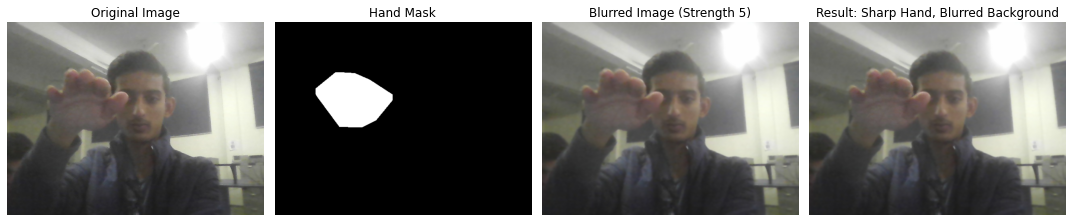

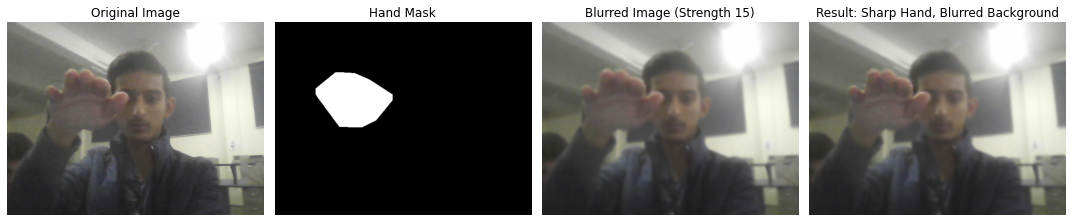

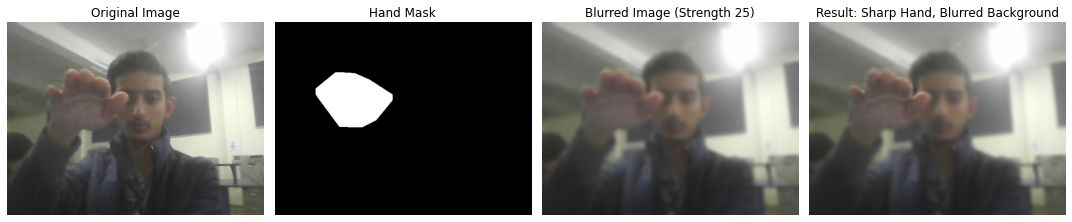

Processing gesture: down


Processing down sequences:   0%|          | 0/460 [00:00<?, ?it/s]

Processing gesture: left


Processing left sequences:   0%|          | 0/460 [00:00<?, ?it/s]

Processing gesture: right


Processing right sequences:   0%|          | 0/460 [00:00<?, ?it/s]

Processing gesture: up


Processing up sequences:   0%|          | 0/460 [00:00<?, ?it/s]

Dataset processing complete. Results saved to D:/FYP/dataset_blur_bg/image_blurred_bg


In [5]:
# Import necessary libraries
import os
import numpy as np
import cv2
from tqdm.notebook import tqdm
from PIL import Image
import mediapipe as mp
import matplotlib.pyplot as plt

def create_directory(directory):
    """Create directory if it doesn't exist."""
    if not os.path.exists(directory):
        os.makedirs(directory)

def process_image_with_blur(image_path, output_path, mp_hands, method='mediapipe', blur_strength=15):
    """
    Blur the background of hand image using either MediaPipe or color segmentation.
    
    Args:
        image_path: Path to input image
        output_path: Path to save processed image
        mp_hands: MediaPipe hands model
        method: 'mediapipe' or 'color_segmentation'
        blur_strength: Strength of blur effect (higher = more blur)
    """
    # Read image with OpenCV (BGR format)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read {image_path}")
        return
    
    # Convert to RGB for MediaPipe
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape
    
    if method == 'mediapipe':
        # Process with MediaPipe hands
        results = mp_hands.process(rgb_image)
        
        # Create a black mask
        mask = np.zeros((h, w), dtype=np.uint8)
        
        # If hand landmarks are detected
        if results.multi_hand_landmarks:
            # Create a convex hull from the hand landmarks
            for hand_landmarks in results.multi_hand_landmarks:
                points = []
                for landmark in hand_landmarks.landmark:
                    x, y = int(landmark.x * w), int(landmark.y * h)
                    points.append([x, y])
                
                # Convert points to numpy array
                points = np.array(points, dtype=np.int32)
                
                # Calculate the convex hull (to get the entire hand shape)
                hull = cv2.convexHull(points)
                
                # Draw the convex hull on the mask
                cv2.fillConvexPoly(mask, hull, 255)
                
                # Add padding around the hand (expand the mask by dilating)
                kernel = np.ones((15, 15), np.uint8)
                mask = cv2.dilate(mask, kernel, iterations=1)
    
    elif method == 'color_segmentation':
        # Convert to HSV for better color segmentation
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # Define range for skin color in HSV
        # Adjust these ranges based on your lighting conditions and skin tones
        lower_skin = np.array([0, 20, 70], dtype=np.uint8)
        upper_skin = np.array([20, 255, 255], dtype=np.uint8)
        
        # Create a binary mask
        mask = cv2.inRange(hsv, lower_skin, upper_skin)
        
        # Apply morphological operations to improve the mask
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.dilate(mask, kernel, iterations=2)
        mask = cv2.erode(mask, kernel, iterations=1)
        mask = cv2.GaussianBlur(mask, (5, 5), 0)
    
    # Create blurred version of the image
    blurred = cv2.GaussianBlur(image, (blur_strength, blur_strength), 0)
    
    # Create result image by combining original hand with blurred background
    # Convert mask to float and expand dimensions for proper blending
    mask_float = np.expand_dims(mask / 255.0, axis=2)
    
    # Blend original image (hand) with blurred image (background)
    result = image * mask_float + blurred * (1 - mask_float)
    
    # Convert result to 8-bit unsigned integer
    result = result.astype(np.uint8)
    
    # Save the result
    cv2.imwrite(output_path, result)
    
    return rgb_image, mask, result  # Return images for visualization

def visualize_blur_processing(image_path, mp_hands, method='mediapipe', blur_strength=15):
    """
    Visualize the background blurring process on a single image.
    """
    # Process the image
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape
    
    if method == 'mediapipe':
        # Process with MediaPipe hands
        results = mp_hands.process(rgb_image)
        
        # Create a black mask
        mask = np.zeros((h, w), dtype=np.uint8)
        
        # If hand landmarks are detected
        if results.multi_hand_landmarks:
            # Create a convex hull from the hand landmarks
            for hand_landmarks in results.multi_hand_landmarks:
                points = []
                for landmark in hand_landmarks.landmark:
                    x, y = int(landmark.x * w), int(landmark.y * h)
                    points.append([x, y])
                
                # Convert points to numpy array
                points = np.array(points, dtype=np.int32)
                
                # Calculate the convex hull (to get the entire hand shape)
                hull = cv2.convexHull(points)
                
                # Draw the convex hull on the mask
                cv2.fillConvexPoly(mask, hull, 255)
                
                # Add padding around the hand (expand the mask by dilating)
                kernel = np.ones((15, 15), np.uint8)
                mask = cv2.dilate(mask, kernel, iterations=1)
    
    elif method == 'color_segmentation':
        # Convert to HSV for better color segmentation
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # Define range for skin color in HSV
        lower_skin = np.array([0, 20, 70], dtype=np.uint8)
        upper_skin = np.array([20, 255, 255], dtype=np.uint8)
        
        # Create a binary mask
        mask = cv2.inRange(hsv, lower_skin, upper_skin)
        
        # Apply morphological operations to improve the mask
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.dilate(mask, kernel, iterations=2)
        mask = cv2.erode(mask, kernel, iterations=1)
        mask = cv2.GaussianBlur(mask, (5, 5), 0)
    
    # Create blurred version of the image
    blurred = cv2.GaussianBlur(rgb_image, (blur_strength, blur_strength), 0)
    
    # Create result image by combining original hand with blurred background
    # Convert mask to float and expand dimensions for proper blending
    mask_float = np.expand_dims(mask / 255.0, axis=2)
    
    # Blend original image (hand) with blurred image (background)
    result = rgb_image * mask_float + blurred * (1 - mask_float)
    
    # Convert result to 8-bit unsigned integer
    result = result.astype(np.uint8)
    
    # Display the images
    plt.figure(figsize=(15, 5))
    plt.subplot(141)
    plt.imshow(rgb_image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(142)
    plt.imshow(mask, cmap='gray')
    plt.title('Hand Mask')
    plt.axis('off')
    
    plt.subplot(143)
    plt.imshow(blurred)
    plt.title(f'Blurred Image (Strength {blur_strength})')
    plt.axis('off')
    
    plt.subplot(144)
    plt.imshow(result)
    plt.title('Result: Sharp Hand, Blurred Background')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return result

def process_dataset_with_blur(data_path, output_path, background_removal_method='mediapipe', blur_strength=15):
    """
    Process the entire dataset to blur backgrounds from hand gesture images.
    
    Args:
        data_path: Path to the original dataset
        output_path: Path to save the processed dataset
        background_removal_method: 'mediapipe' or 'color_segmentation'
        blur_strength: Strength of blur effect (higher = more blur)
    """
    # Initialize MediaPipe Hands
    mp_hands = mp.solutions.hands.Hands(
        static_image_mode=True,
        max_num_hands=2,
        min_detection_confidence=0.5
    )
    
    # Create output directory
    create_directory(output_path)
    
    # Iterate through gesture folders
    for gesture in ['down', 'left', 'right', 'up']:
        gesture_path = os.path.join(data_path, gesture)
        output_gesture_path = os.path.join(output_path, gesture)
        create_directory(output_gesture_path)
        
        print(f"Processing gesture: {gesture}")
        
        # Iterate through sequence folders for this gesture
        seq_folders = [f for f in os.listdir(gesture_path) if os.path.isdir(os.path.join(gesture_path, f))]
        
        for seq_folder in tqdm(seq_folders, desc=f"Processing {gesture} sequences"):
            seq_path = os.path.join(gesture_path, seq_folder)
            output_seq_path = os.path.join(output_gesture_path, seq_folder)
            create_directory(output_seq_path)
            
            # Process frames in this sequence
            frame_files = [f for f in os.listdir(seq_path) if f.endswith('.jpg') or f.endswith('.png')]
            
            for frame_file in frame_files:
                frame_path = os.path.join(seq_path, frame_file)
                output_frame_path = os.path.join(output_seq_path, frame_file)
                
                # Process the image to blur background
                process_image_with_blur(frame_path, output_frame_path, mp_hands, 
                                       method=background_removal_method,
                                       blur_strength=blur_strength)
    
    # Release MediaPipe resources
    mp_hands.close()
    
    print(f"Dataset processing complete. Results saved to {output_path}")

# Test on a sample image
def test_blur_on_sample_image(data_path, method='mediapipe', blur_strengths=[5, 15, 25]):
    """Test background blurring on a sample image with different blur strengths."""
    # Initialize MediaPipe Hands
    mp_hands = mp.solutions.hands.Hands(
        static_image_mode=True,
        max_num_hands=2,
        min_detection_confidence=0.5
    )
    
    # Find a sample image
    sample_image_path = None
    for gesture in ['down', 'left', 'right', 'up']:
        gesture_path = os.path.join(data_path, gesture)
        if os.path.exists(gesture_path):
            seq_folders = [f for f in os.listdir(gesture_path) if os.path.isdir(os.path.join(gesture_path, f))]
            if seq_folders:
                seq_path = os.path.join(gesture_path, seq_folders[0])
                frame_files = [f for f in os.listdir(seq_path) if f.endswith('.jpg') or f.endswith('.png')]
                if frame_files:
                    sample_image_path = os.path.join(seq_path, frame_files[0])
                    print(f"Testing with sample image: {sample_image_path}")
                    break
    
    if sample_image_path:
        # Compare different blur strengths
        results = []
        
        # Original image
        image = cv2.imread(sample_image_path)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results.append(("Original", rgb_image))
        
        # Test different blur strengths
        for strength in blur_strengths:
            result = visualize_blur_processing(sample_image_path, mp_hands, method=method, blur_strength=strength)
            results.append((f"Blur Strength: {strength}", result))
    
    # Release MediaPipe resources
    mp_hands.close()

# Example usage
data_path = "D:/FYP/Dataset_Generation/image"  # Change to your dataset path
test_blur_on_sample_image(data_path, method='mediapipe', blur_strengths=[5, 15, 25])

# Process the entire dataset
data_path = "D:/FYP/Dataset_Generation/image"  # Change to your dataset path
output_path = "D:/FYP/dataset_blur_bg/image_blurred_bg"  # Change to your desired output path
process_dataset_with_blur(data_path, output_path, background_removal_method='mediapipe', blur_strength=15)

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import LeaveOneGroupOut, KFold
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Custom Dataset class for hand gestures
class HandGestureDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


# Function to detect skin pixels for hand segmentation
def detect_skin(img_cv):
    """
    Detect skin pixels in an image using HSV color space.
    
    Args:
        img_cv: OpenCV image in BGR format
    
    Returns:
        mask: Binary mask where skin pixels are white
    """
    # Convert to HSV color space
    img_hsv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2HSV)
    
    # Define range for skin color in HSV
    lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)
    
    # Create binary mask
    mask = cv2.inRange(img_hsv, lower_skin, upper_skin)
    
    # Additional morphological operations to improve the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.dilate(mask, kernel, iterations=2)
    
    return mask


# Function to blur background while keeping hand in focus
def blur_background(img_cv, mask, blur_strength=21):
    """
    Blur the background of an image while keeping the hand in focus.
    
    Args:
        img_cv: OpenCV image in BGR format
        mask: Binary mask where hand pixels are white
        blur_strength: Strength of the Gaussian blur (odd number)
    
    Returns:
        result: Image with blurred background
    """
    # Ensure blur_strength is odd
    if blur_strength % 2 == 0:
        blur_strength += 1
    
    # Apply Gaussian blur to the entire image
    blurred = cv2.GaussianBlur(img_cv, (blur_strength, blur_strength), 0)
    
    # Create inverted mask for background
    mask_inv = cv2.bitwise_not(mask)
    
    # Get the background from the blurred image
    background = cv2.bitwise_and(blurred, blurred, mask=mask_inv)
    
    # Get the hand from the original image
    hand = cv2.bitwise_and(img_cv, img_cv, mask=mask)
    
    # Combine hand and blurred background
    result = cv2.add(hand, background)
    
    return result


# Function to load and preprocess the dataset
def load_dataset(data_path):
    """
    Load and preprocess the hand gesture dataset with background blurring.
    
    Args:
        data_path: Path to the dataset directory
        
    Returns:
        X: Sequences of images with shape (num_sequences, channels, frames, height, width)
        y: Labels corresponding to gestures (0: down, 1: left, 2: right, 3: up)
        subject_ids: IDs of subjects for cross-validation
    """
    # Placeholder arrays for data, labels, and subject IDs
    sequences = []
    labels = []
    subject_ids = []
    
    # Map gesture names to numerical labels
    gesture_map = {'down': 0, 'left': 1, 'right': 2, 'up': 3}
    
    # Image transformation pipeline
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Using power of 2 dimensions for better downsampling
        transforms.ToTensor(),  # Converts to [0,1] range and changes to CxHxW format
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1] range
    ])
    
    # Iterate through gesture folders
    for gesture in ['down', 'left', 'right', 'up']:
        gesture_path = os.path.join(data_path, gesture)
        
        # Iterate through sequence folders for this gesture
        for seq_folder in os.listdir(gesture_path):
            seq_path = os.path.join(gesture_path, seq_folder)
            
            if os.path.isdir(seq_path):
                # Extract subject ID from sequence folder name (assuming format contains subject ID)
                # Modify this according to your actual folder naming convention
                subject_id = int(seq_folder.split('_')[0])
                
                # Load frames for this sequence
                frame_files = sorted([f for f in os.listdir(seq_path) if f.endswith('.jpg') or f.endswith('.png')])
                
                if len(frame_files) > 0:
                    # Load and normalize frames
                    frames = []
                    for frame_file in frame_files:
                        frame_path = os.path.join(seq_path, frame_file)
                        
                        # Open image with OpenCV for skin detection and background blurring
                        img_cv = cv2.imread(frame_path)
                        if img_cv is not None:
                            # Detect skin pixels (hand region)
                            skin_mask = detect_skin(img_cv)
                            
                            # Blur background while keeping hand in focus
                            processed_img = blur_background(img_cv, skin_mask, blur_strength=15)
                            
                            # Convert back to PIL for further processing
                            processed_pil = Image.fromarray(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
                            
                            # Convert to grayscale and apply transforms
                            img_gray = processed_pil.convert('L')
                            img_tensor = transform(img_gray)
                            frames.append(img_tensor)
                    
                    # Pad or truncate sequence to fixed length (8 frames - power of 2)
                    target_frames = 8
                    if len(frames) < target_frames:
                        # Pad with zeros if sequence is too short
                        for _ in range(target_frames - len(frames)):
                            frames.append(torch.zeros_like(frames[0]))
                    elif len(frames) > target_frames:
                        # Truncate if sequence is too long
                        frames = frames[:target_frames]
                    
                    # Stack frames along a new dimension
                    sequence_tensor = torch.stack(frames)  # Shape: [frames, channels, height, width]
                    sequence_tensor = sequence_tensor.permute(1, 0, 2, 3)  # Reshape to [channels, frames, height, width]
                    
                    # Add sequence to dataset
                    sequences.append(sequence_tensor)
                    labels.append(gesture_map[gesture])
                    subject_ids.append(subject_id)
    
    # Convert lists to tensors
    X = torch.stack(sequences)
    y = torch.tensor(labels, dtype=torch.long)
    subject_ids = np.array(subject_ids)
    
    return X, y, subject_ids

# Basic 3D convolution block
class Conv3DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(Conv3DBlock, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


# Dense Block for 3D DenseNet
class DenseBlock3D(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock3D, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(self._make_dense_layer(in_channels + i * growth_rate, growth_rate))
    
    def _make_dense_layer(self, in_channels, growth_rate):
        return nn.Sequential(
            nn.BatchNorm3d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(in_channels, 4 * growth_rate, kernel_size=1, bias=False),
            nn.BatchNorm3d(4 * growth_rate),
            nn.ReLU(inplace=True),
            nn.Conv3d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        )
    
    def forward(self, x):
        features = [x]
        for layer in self.layers:
            new_feature = layer(torch.cat(features, 1))
            features.append(new_feature)
        return torch.cat(features, 1)


# Transition Layer for 3D DenseNet
class TransitionLayer3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer3D, self).__init__()
        self.layers = nn.Sequential(
            nn.BatchNorm3d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.AvgPool3d(kernel_size=2, stride=2)
        )
    
    def forward(self, x):
        return self.layers(x)


# 3D DenseNet Model
class DenseNet3D(nn.Module):
    def __init__(self, growth_rate=12, block_config=(2, 4, 6), num_init_features=16, 
                 compression_rate=0.5, num_classes=4):
        super(DenseNet3D, self).__init__()
        
        # First convolution and pooling
        self.features = nn.Sequential(
            nn.Conv3d(1, num_init_features, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm3d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
        
        # Dense Blocks
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            # Add a dense block
            block = DenseBlock3D(
                in_channels=num_features,
                growth_rate=growth_rate,
                num_layers=num_layers
            )
            self.features.add_module(f'denseblock{i+1}', block)
            num_features += num_layers * growth_rate
            
            # Add a transition layer (except after the last block)
            if i != len(block_config) - 1:
                out_features = int(num_features * compression_rate)
                trans = TransitionLayer3D(num_features, out_features)
                self.features.add_module(f'transition{i+1}', trans)
                num_features = out_features
        
        # Final batch norm
        self.features.add_module('norm_final', nn.BatchNorm3d(num_features))
        self.features.add_module('relu_final', nn.ReLU(inplace=True))
        
        # Global Average Pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.classifier = nn.Linear(num_features, num_classes)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        features = self.features(x)
        out = self.avgpool(features)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


# Function to train the model for one epoch
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    train_loss = running_loss / total
    train_acc = 100. * correct / total
    
    return train_loss, train_acc


# Function to evaluate the model
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Save predictions and targets for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    test_loss = running_loss / total
    test_acc = 100. * correct / total
    
    return test_loss, test_acc, all_preds, all_targets


def train_and_evaluate(X, y, subject_ids, model_type='densenet'):
    """
    Train and evaluate the 3D-CNN model using k-fold cross-validation
    with stratification across subjects.
    
    Args:
        X: Sequences of images tensor
        y: Labels tensor
        subject_ids: Subject IDs for cross-validation
        model_type: Type of model to use
        
    Returns:
        results: Dictionary containing evaluation results
        best_model_state: State dict of the best performing model
    """
    # Check for CUDA availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Initialize KFold cross-validator
    n_splits = 5  # 5-fold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Initialize lists to store results
    subject_accuracies = []
    all_y_true = []
    all_y_pred = []
    
    # Cross-validation parameters
    num_epochs = 25
    batch_size = 16
    
    # Track the best model across all folds
    best_overall_acc = 0
    final_best_model_state = None
    
    # Iterate through folds
    for fold, (train_idx, test_idx) in enumerate(kf.split(X.numpy()), 1):
        print(f"\n--- Fold {fold}/{n_splits} ---")
        
        # Create PyTorch datasets and dataloaders
        train_dataset = HandGestureDataset(X[train_idx], y[train_idx])
        test_dataset = HandGestureDataset(X[test_idx], y[test_idx])
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # Create the model
        model = DenseNet3D(growth_rate=12, block_config=(2, 4, 4), num_init_features=16).to(device)
        
        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer, 
            max_lr=0.01,
            steps_per_epoch=len(train_loader),
            epochs=num_epochs
        )
        
        # Variables for early stopping
        best_test_acc = 0
        best_model_state = None
        patience = 15
        patience_counter = 0
        
        # Training loop
        for epoch in range(num_epochs):
            # Train for one epoch
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            
            # Evaluate on test set
            test_loss, test_acc, _, _ = evaluate(model, test_loader, criterion, device)
            
            # Print progress
            print(f'Epoch {epoch+1}/{num_epochs}: '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
                  f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
            
            # Check for improvement
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                best_model_state = model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        
        # Load best model for final evaluation
        model.load_state_dict(best_model_state)
        
        # Final evaluation
        _, final_test_acc, y_pred, y_true = evaluate(model, test_loader, criterion, device)
        
        # Store results
        subject_accuracies.append(final_test_acc / 100.0)
        all_y_true.extend(y_true)
        all_y_pred.extend(y_pred)
        
        print(f"Fold {fold} Final Test Accuracy: {final_test_acc:.2f}%")
        
        # Keep track of the best model across all folds
        if final_test_acc > best_overall_acc:
            best_overall_acc = final_test_acc
            final_best_model_state = best_model_state.copy()
    
    # Calculate overall metrics
    overall_accuracy = np.mean(subject_accuracies)
    conf_matrix = confusion_matrix(all_y_true, all_y_pred)
    
    # Store results
    results = {
        'subject_accuracies': subject_accuracies,
        'overall_accuracy': overall_accuracy,
        'confusion_matrix': conf_matrix,
        'y_true': all_y_true,
        'y_pred': all_y_pred
    }
    
    return results, final_best_model_state
# Function to visualize results
def visualize_results(results, model_name='densenet'):
    """
    Visualize the cross-validation results.
    
    Args:
        results: Dictionary containing evaluation results
        model_name: Name of the model
    """
    # Plot subject accuracies
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(results['subject_accuracies'])), results['subject_accuracies'])
    plt.axhline(y=results['overall_accuracy'], color='r', linestyle='-', 
                label=f"Overall: {results['overall_accuracy']:.4f}")
    plt.xlabel('Subject')
    plt.ylabel('Accuracy')
    plt.title(f'Leave-One-Subject-Out Cross-Validation Results ({model_name})')
    plt.legend()
    plt.ylim(0, 1)
    plt.savefig(f'subject_accuracies_{model_name}.png')
    plt.close()
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    gesture_names = ['Down', 'Left', 'Right', 'Up']
    conf_matrix = results['confusion_matrix']
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=gesture_names, yticklabels=gesture_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix ({model_name})')
    plt.savefig(f'confusion_matrix_{model_name}.png')
    plt.close()


# Main execution
if __name__ == "__main__":
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)
    
    # Path to your dataset
    data_path = r"D:\FYP\Dataset_Generation\image"
    
    # Load and preprocess the dataset
    X, y, subject_ids = load_dataset(data_path)
    
    # Print dataset info
    print(f"Dataset shape: {X.shape}")
    print(f"Number of sequences: {len(X)}")
    print(f"Number of subjects: {len(np.unique(subject_ids))}")
    
    # Run with DenseNet model
    print("\n--- Training with 3D DenseNet ---")
    densenet_results, best_model_state = train_and_evaluate(X, y, subject_ids, model_type='densenet')
    
    # Print overall results
    print("\n--- Overall Results ---")
    print(f"DenseNet Overall Accuracy: {densenet_results['overall_accuracy']:.4f}")
    
    # Visualize results
    print("\nGenerating visualization plots...")
    visualize_results(densenet_results, 'densenet')
    
    # Save the model
    print("\nSaving model...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DenseNet3D(growth_rate=12, block_config=(2, 4, 4), num_init_features=16).to(device)
    model.load_state_dict(best_model_state)
    
    # Save the model state dictionary
    torch.save(model.state_dict(), 'hand_gesture_model.pth')
    print("Model saved successfully to 'hand_gesture_model.pth'")
    
    print("\nDone! Results saved as PNG files.")

Dataset shape: torch.Size([1840, 1, 8, 64, 64])
Number of sequences: 1840
Number of subjects: 460

--- Training with 3D DenseNet ---
Using device: cpu

--- Fold 1/5 ---
Epoch 1/10: Train Loss: 1.2337, Train Acc: 47.15%, Test Loss: 1.0184, Test Acc: 60.33%
Epoch 2/10: Train Loss: 0.9068, Train Acc: 69.36%, Test Loss: 0.7780, Test Acc: 69.84%
Epoch 3/10: Train Loss: 0.6454, Train Acc: 83.29%, Test Loss: 0.5256, Test Acc: 84.51%


KeyboardInterrupt: 